# Assignment 9 - Monte Carlo Modeling of low-density gas near a moving wall

## Authors
P. Mocz
and 
B.W. Holwerda 

## Learning Goals
* how to model gas particles.
* effective use of a Monte-Carlo approach
* optimizing and contrasting MC models. 

## Keywords

Monte-Carlo modeling, gas models, friction, animation, time evolution

## Companion Content

Based on this article:
https://medium.com/swlh/create-your-own-direct-simulation-monte-carlo-with-python-3b9f26fa05ab


## Summary

A dilute gas is an unique problem environment where the system may need to be modeled as individual particles (or ones that stand in for a set of particles) and use numpy random and what we know of the behavior to model the final system's behavior. In this case a layer of gas close to a moving surface.

<hr>


## Student Name and ID:



## Date:

<hr>

In [1]:
## some important modules/functions we will need
import numpy as np
import scipy
from scipy import special

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import random

import glob
import os

from dsmc import DSMC
%matplotlib inline

# %config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20


we learn how to simulate dilute gas with the Direct Simulation Monte Carlo (DSMC) method. This approach is useful when gas is weakly collisional. We will look at the Rayleigh Problem: the response of rarified gas between two plates after one suddenly starts moving.



## Rarefied Gas Modeling

Rarefied flows cannot be accurately simulated using fluid (Navier-Stokes) equations. By rarified or ‘dilute’, we mean that the mean free path $\lambda$ of a molecule is of the same order (or greater) than a representative physical length scale $L$ in the problem. The dimensionless Knudsen number, $Kn$, is a useful measure to identify when we are in this regime:

$$ Kn = \lambda/L $$

A Knudsen number of $Kn>0.1$ means that the continuum fluid description breaks down. To simulate such a fluid, we will use a probabilistic Monte Carlo approach to solve the Boltzmann equation for finite Knudsen number.

The mean free path $\lambda$ of a fluid is defined as:

$$ \lambda {1 \over \sqrt{2} \pi \sigma^2 n } $$

where $n$ is the number density of the molecule and $\sigma$ is the molecule's effective size.

The Setup

The setup is as follows. Consider dilute gas in thermal equilibrium with temperature T₀ between two infinite plates:

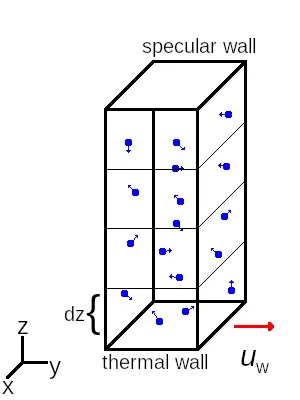

The top plate is a specular (reflective) wall which will simply bounce back particles that hit it. The bottom plate is a thermal wall with temperature $Tw=T_0$ that suddenly moves in the y-direction with speed $u_w$ at time $t=0$. The plates are separated by a distance $Lz$ along the z-direcion, which the DSMC method will break up into ‘collision’ cells of height $dz$. The question of the Rayleigh problem is to understand how the dilute gas will react to the sudden movement of the plate.

### Direct Simulation Monte Carlo

The DSMC method will treat the dilute gas as a collection of simulation particles, each with:
* position $r_i = [x_i, y_i, z_i]$ 
* velocity $v_i = [vx_i, vy_i, vz_i]$ 

It is important to note that each simulation particle may represent $N_e$ physical particles, where $N_e$ need not be 1.

In a loop over time steps, the particles will undergo three steps
* Drift
* Wall collisions
* Particle-Particle Collisions (via probabilistic Monte Carlo)

We describe these steps in detail below, but first we define some simulation parameters.


In [5]:
# Simulation parameters
uw              = 0.2       # lower wall velocity
Tw              = 1         # wall temperature
n0              = 0.001     # density
N               = 50000     # number of sampling particles
Ncell           = 50        # number of 'collision' cells


lambda_mfp      = 1/(np.sqrt(2)*np.pi*n0)    # mean free path ~= 225
Lz              = 10*lambda_mfp              # height of box  ~= 2250.8
v_mean = (2/np.sqrt(np.pi)) * np.sqrt(2*Tw)  # mean speed of thermal particles
tau             = lambda_mfp / v_mean        # mean-free time
dz              = Lz/Ncell                   # cell height
vol             = Lz*dz*dz/Ncell             # cell volume
Ne              = n0*Lz*dz*dz/N   # number of real particles each sampling particle represents


### Initial Conditions

In the initial conditions, the particles are distributed uniform randomly within the spatial domain. The particle velocities are drawn from a Maxwellian (Gaussian) distribution with variance T₀=1. The simulation code will use units of m=σ=k T₀=1, where m is the particle mass and k is Boltzmann’s constant.

### Exercise 1

How would one set the initial conditions for x,y,x and velocities for the particles? express in python code below. Use the simulation parameters above and the numpy random library.

In [7]:
# student work here


### Drift

The drift step is very simple. Particles stream with their velocities, and in each timestep $\Delta t$, their positions are updated as follows

$$ r_{(i+1)} = r_i + \Delta t \times v_i $$

Or, in terms of code:

In [9]:
dt = 1
# drift
x += dt*vx
y += dt*vy
z += dt*vz

## Wall Collisions

After drifting, the particles may hit the top or the bottom wall, and these boundary conditions need to be accounted for.

### Top (non-moving, reflective) wall

The top specular (reflective) wall is hit if the particle position becomes $z>Lz$. In such a case, we must trace the straight-line trajectory of the top wall and bounce it back. The particle position is reflected across top wall, and the normal component of the velocity ($vz$) reverse sign. This can be accomplished with a few lines of code:

In [10]:
# collide specular wall (z=Lz)
# trace the straight-line trajectory to the top wall, bounce it back
hit_top = z > Lz
dt_ac = (z[hit_top]-Lz) / vz[hit_top] # time after collision
vz[hit_top] = -vz[hit_top]  # reverse normal component of velocity
z[hit_top]  = Lz + dt_ac * vz[hit_top]

### Bottom (moving) wall

Next, the bottom thermal wall needs to be accounted for. A particle hits the wall if its position becomes z<0. In this case, the particle’s velocity needs to be reset to a biased Maxwellian upon impact:

where $r_G$ and $r’_G$ are numbers drawn from a random Gaussian, and $r$ is drawn randomly from the uniform interval (0,1).
Following the point of impact, the particle streams off with its new velocity, so its position needs to be corrected to take that into account.
Applying this boundary condition is accomplished with the following lines of code:

In [11]:
# collide thermal wall (z=0)
# reset velocity to a biased maxwellian upon impact
hit_bot = z < 0
dt_ac = z[hit_bot] / vz[hit_bot]
x[hit_bot] -= dt_ac * vx[hit_bot]
y[hit_bot] -= dt_ac * vy[hit_bot]
Nbot = np.sum( hit_bot )

vx[hit_bot] = np.sqrt(Tw) * np.random.normal(0, 1, Nbot) 
vy[hit_bot] = np.sqrt(Tw) * np.random.normal(0, 1, Nbot) + uw
vz[hit_bot] = np.sqrt( -2 * Tw * np.log(np.random.random(Nbot)) )

x[hit_bot] += dt_ac * vx[hit_bot]
y[hit_bot] += dt_ac * vy[hit_bot]
z[hit_bot]  = dt_ac * vz[hit_bot]

## Probabilistic Particle-Particle Collisions

Finally comes the heart of the DSMC method. In each ‘collision’ cell, a set of representative collisions is processed at each time step. It is important that the cell size dz is smaller than the mean free path λ and that there are enough particles so each cell has at least ~1000. A number of particle pairs i and j within the cell are selected at random and collide with probability that is proportional to their relative velocity:

$$ p_{collide}(i,j) \propto |v_i - v_j|$$


The collisions are processed using an acceptance-rejection scheme. For each cell, we randomly select M_cand candidate pairs for collision, calculated as:

$$ M_{cand} = { N_c^2 \pi \sigma^2 v_{r,max} N_e \Delta t \over 2 V_c}

where $N_c$ is the number of particles in the cell, $V_c$ is the volume of the cell, and $v_rmax$ is an upper limit estimate for the maximum relative velocity between particles. It is expensive to calculate v_rmax exactly because it requires a pairwise sum over particles, but the method will be accurate as long as an overestimate is given. However, you do not want to overestimate v_rmax by too much because that will also slow the code down as it means more candidate particle pairs have to be processed.

For each candidate particle pair, draw a random number r in (0,1) and ‘accept’ the pair for collision if:

$$ { |v_i - v_j| \over v_{r,max}} > r $$

The expected number of collisions $M_{coll}$ out of the $M_{cand}$ candidate pairs is:

$$ { M_{coll} \over M_{cand}} = { <v_r> \over v_{r,max} }$$

where $<v_r>$ is the average relative velocity of the particles in the cell.

The outcome of the collision is a **hard-body collision**, in which the particles conserve momentum and energy and scatter off in a random direction. In such a collision, the particle velocities of particles $i$ and $j$ are changed to:

$$ v'_i = v_{cm} + 1/2 v'_r $$

$$ v'_j = v_{cm} - 1/2 v'_r $$

where

$$ v_{cm} = {1 \over 2} (v_i + v_j) $$

is the center-of-mass velocity of the two particles and

$$ v'_r = v_r (sin\theta cos\phi, sin\theta sin\phi, cos\theta) $$

is the randomly re-oriented relative velocity between the two particles. The angles are chosen randomly according to:

$$ cos \theta = 2r-1 $$

$$ sin \theta = \sqrt{1 - cos^2 \theta} $$

$$ \phi = 2\pi r' $$

where again r and r’ are random numbers drawn from the interval (0,1). The above sampling picks out a random direction on the surface of a sphere in a uniform manner.
The following part of the code handles Monte Carlo particle collisions:


In [12]:
# collide particles using acceptance--rejection scheme
v_rel_max = 6 # (over-)estimate upper limit to relative vel.
# loop over cells
for j in range(Ncell):
    
    in_cell = (j*dz < z) & (z < (j+1)*dz)
    Nc = np.sum( in_cell )
    x_c = x[in_cell]
    y_c = y[in_cell]
    z_c = z[in_cell]
    vx_c = vx[in_cell]
    vy_c = vy[in_cell]
    vz_c = vz[in_cell]
    
    M_cand = np.ceil(Nc**2 * np.pi * v_rel_max * Ne * dt/(2*vol)).astype(int)
        
    # propose collision between i and j
    for k in range(M_cand):
        
        r_fac = np.random.random()
        i_prop = np.random.randint(Nc)
        j_prop = np.random.randint(Nc)
        
        v_rel = np.sqrt((vx_c[i_prop]-vx_c[j_prop])**2 + (vy_c[i_prop]-vy_c[j_prop])**2 + (vz_c[i_prop]-vz_c[j_prop])**2 )
        
        # accept collision with appropriate probability
        if v_rel > r_fac*v_rel_max:
            
            # process collision -- hard sphere
            vx_cm = 0.5 * (vx_c[i_prop] + vx_c[j_prop])
            vy_cm = 0.5 * (vy_c[i_prop] + vy_c[j_prop])
            vz_cm = 0.5 * (vz_c[i_prop] + vz_c[j_prop])
            cos_theta = 2 * np.random.random() - 1
            sin_theta = np.sqrt( 1 - cos_theta**2 )
            phi       = 2 * np.pi * np.random.random()
            vx_p = v_rel * sin_theta * np.cos(phi)
            vy_p = v_rel * sin_theta * np.sin(phi)
            vz_p = v_rel * cos_theta
            vx_c[i_prop] = vx_cm + 0.5*vx_p
            vy_c[i_prop] = vy_cm + 0.5*vy_p
            vz_c[i_prop] = vz_cm + 0.5*vz_p
            vx_c[j_prop] = vx_cm - 0.5*vx_p
            vy_c[j_prop] = vy_cm - 0.5*vy_p
            vz_c[j_prop] = vz_cm - 0.5*vz_p
            
    x[in_cell]  = x_c 
    y[in_cell]  = y_c 
    z[in_cell]  = z_c
    vx[in_cell] = vx_c 
    vy[in_cell] = vy_c 
    vz[in_cell] = vz_c

### Putting it together

rather than calling different functions for each of the above, we will put everything together in a single program. You can import that from the dsmc.py file like so:

In [ ]:
from dsmc import DSMC

### input and output

the function DSMC uses a series of input parameters, each with preset defaults:

         uw              = 0.2       ,# lower wall velocity
         Tw              = 1         ,# wall temperature
         n0              = 0.001     ,# density
         N               = 50000     ,# number of sampling particles
         Nsim            = 3         ,# number of simulations to run
         Ncell           = 50        ,# number of cells
         Nmft            = 20        ,# number of mean-free times to run simulation
         plotRealTime    = False     ,# True      # animate
         verbose         = True      ,# print comments?
         imfile         = 'dsmc.png'  # file to save final plot to
         
So rather than changing some of the values from default, we can simply re-run an iteration of this MC with different inputs, and, if we so choose, save it in a differently named image file.

The function returns an array of the number of collisions over time *averaged* over the number of simulations.

The following assignments are to explore the effects of input on the MC outcome. 

### Exercise 2 

Run the simulation in default mode. How long does it take to execute? How could you speed things up? 

In [1]:
# student work here


### Exercise 3 - effect of wall speed on motion away from the wall

what happens if one increases the wall speed? Run single simulation with uw=0.2, 1 and 10. Show the resulting figures.

In [2]:
#student work here


*student written answer here*

### Exercise 4 - effect of wall speed on collisions 

plot the average number of collisions as a function of time for the three scenarios above.

In [3]:
# student work here


### Exercise 5 - effect of wall speed on collisions

what happens to the collisions if the wall speed is very high (higher than unity)? 

*student answer here*

### Exercise 6 -  Making an animation

Below is the code of making an animation of all the snapshots saved if you switch on plotRealTime=True.

Run a single simulation with uw=0.2 but with plot realtime on. 

In [4]:
# student work here



image_arrays shape: (500,)


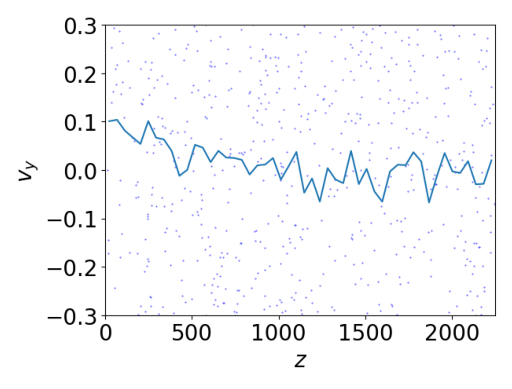

In [3]:
import glob

#read all the .png files in directory called `steps`
files = glob.glob(r"anim/*.png")

from PIL import Image

image_array = []

for my_file in files:
    
    image = Image.open(my_file)
    image_array.append(image)

print('image_arrays shape:', np.array(image_array).shape)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and axes objects
fig, ax = plt.subplots()
ax.set_axis_off()

# Set the initial image
im = ax.imshow(image_array[0], animated=True)

def update(i):
    im.set_array(image_array[i])
    return im, 

# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

# Show the animation
plt.show()

animation_fig.save("dsmc_animated.gif")

### Exercise 7 - what happens close to the moving wall?

Open the animated gif in the browser. This shows you a close-up of the layer close to the wall and the speed of the particles. The line is the average speed. What do you notice?


*student answer here*

### Exercise 8 - Applications

What is the phenomenon of a moving plate and its interaction with gas particles called? Can you think of real-world examples where this would be appliccable? 

*student answer here*

<hr>